# Data Preprocessing
This notebook describes the preprocessing steps and a quick exploratory analysis:

In [1]:
import pandas as pd
import networkx as nx
import ast
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import entropy, pointbiserialr
from math import log

Loading the data:

In [2]:
data = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
data.head()

,language,sentence,n,edgelist,root
0,Japanese,2,23,"[(6, 4), (2, 6), (2, 23), (20, 2), (15, 20), (...",10
1,Japanese,5,18,"[(8, 9), (14, 8), (4, 14), (5, 4), (1, 2), (6,...",10
2,Japanese,8,33,"[(2, 10), (2, 14), (4, 2), (16, 4), (6, 16), (...",3
3,Japanese,11,30,"[(30, 1), (14, 24), (21, 14), (3, 21), (7, 3),...",30
4,Japanese,12,19,"[(19, 13), (16, 19), (2, 16), (4, 10), (4, 15)...",11


Next we check the types and nulls values per column of the training data. No null values are found:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10500 entries, 0 to 10499
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   language  10500 non-null  object
 1   sentence  10500 non-null  int64 
 2   n         10500 non-null  int64 
 3   edgelist  10500 non-null  object
 4   root      10500 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 410.3+ KB


Now we can check some basic statistics of the numeric columns.
- On average each sentence has $18.8$ words
- The root predicted node can be from the 1st till the 68th node (depending the size of the sentence)

In [4]:
data.describe()

,sentence,n,root
count,10500.000000,10500.000000,10500.000000
mean,494.778000,18.807524,9.844476
std,290.256632,8.190593,7.207740
min,2.000000,3.000000,1.000000
25%,233.500000,13.000000,4.000000
50%,483.000000,18.000000,8.000000
75%,742.250000,23.000000,14.000000
max,995.000000,70.000000,68.000000


In the training data we can find 21 languages with 500 sentences for each language, producing $10,500$ total rows of the training data:

In [5]:
print('Total languages: ' + str(data[['language']].value_counts().shape[0]))
data[['language']].value_counts()

Total languages: 21


language  
Arabic        500
Italian       500
Thai          500
Swedish       500
Spanish       500
Russian       500
Portuguese    500
Polish        500
Korean        500
Japanese      500
Indonesian    500
Chinese       500
Icelandic     500
Hindi         500
German        500
Galician      500
French        500
Finnish       500
English       500
Czech         500
Turkish       500
Name: count, dtype: int64

Now we can visualize the distribution of words per sentence:

Text(0.5, 0, 'Words in sentence')

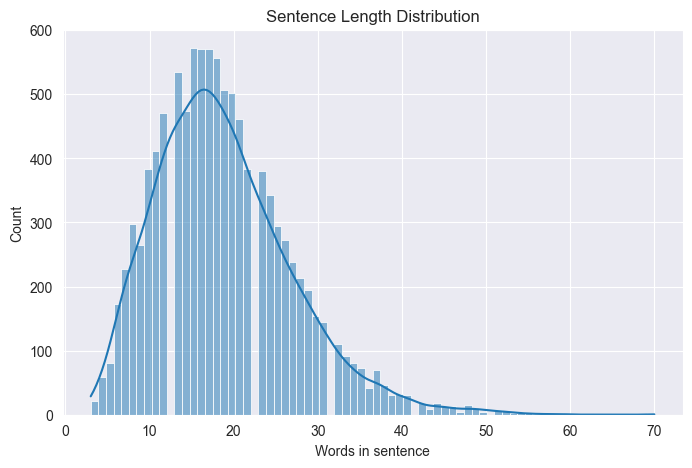

In [6]:
plt.figure(figsize=(8, 5))
sns.set_style("darkgrid")
sns.histplot(data=data, x="n", kde=True)
plt.title('Sentence Length Distribution')
plt.ylabel('Count')
plt.xlabel('Words in sentence')

The distribution is positively skewed with a peak on the left and a long tail extending to the right.

However, not every language follows the same distribution. Different languages follow different distributions since even for the same sentences, they may depict the words in an alternative way:

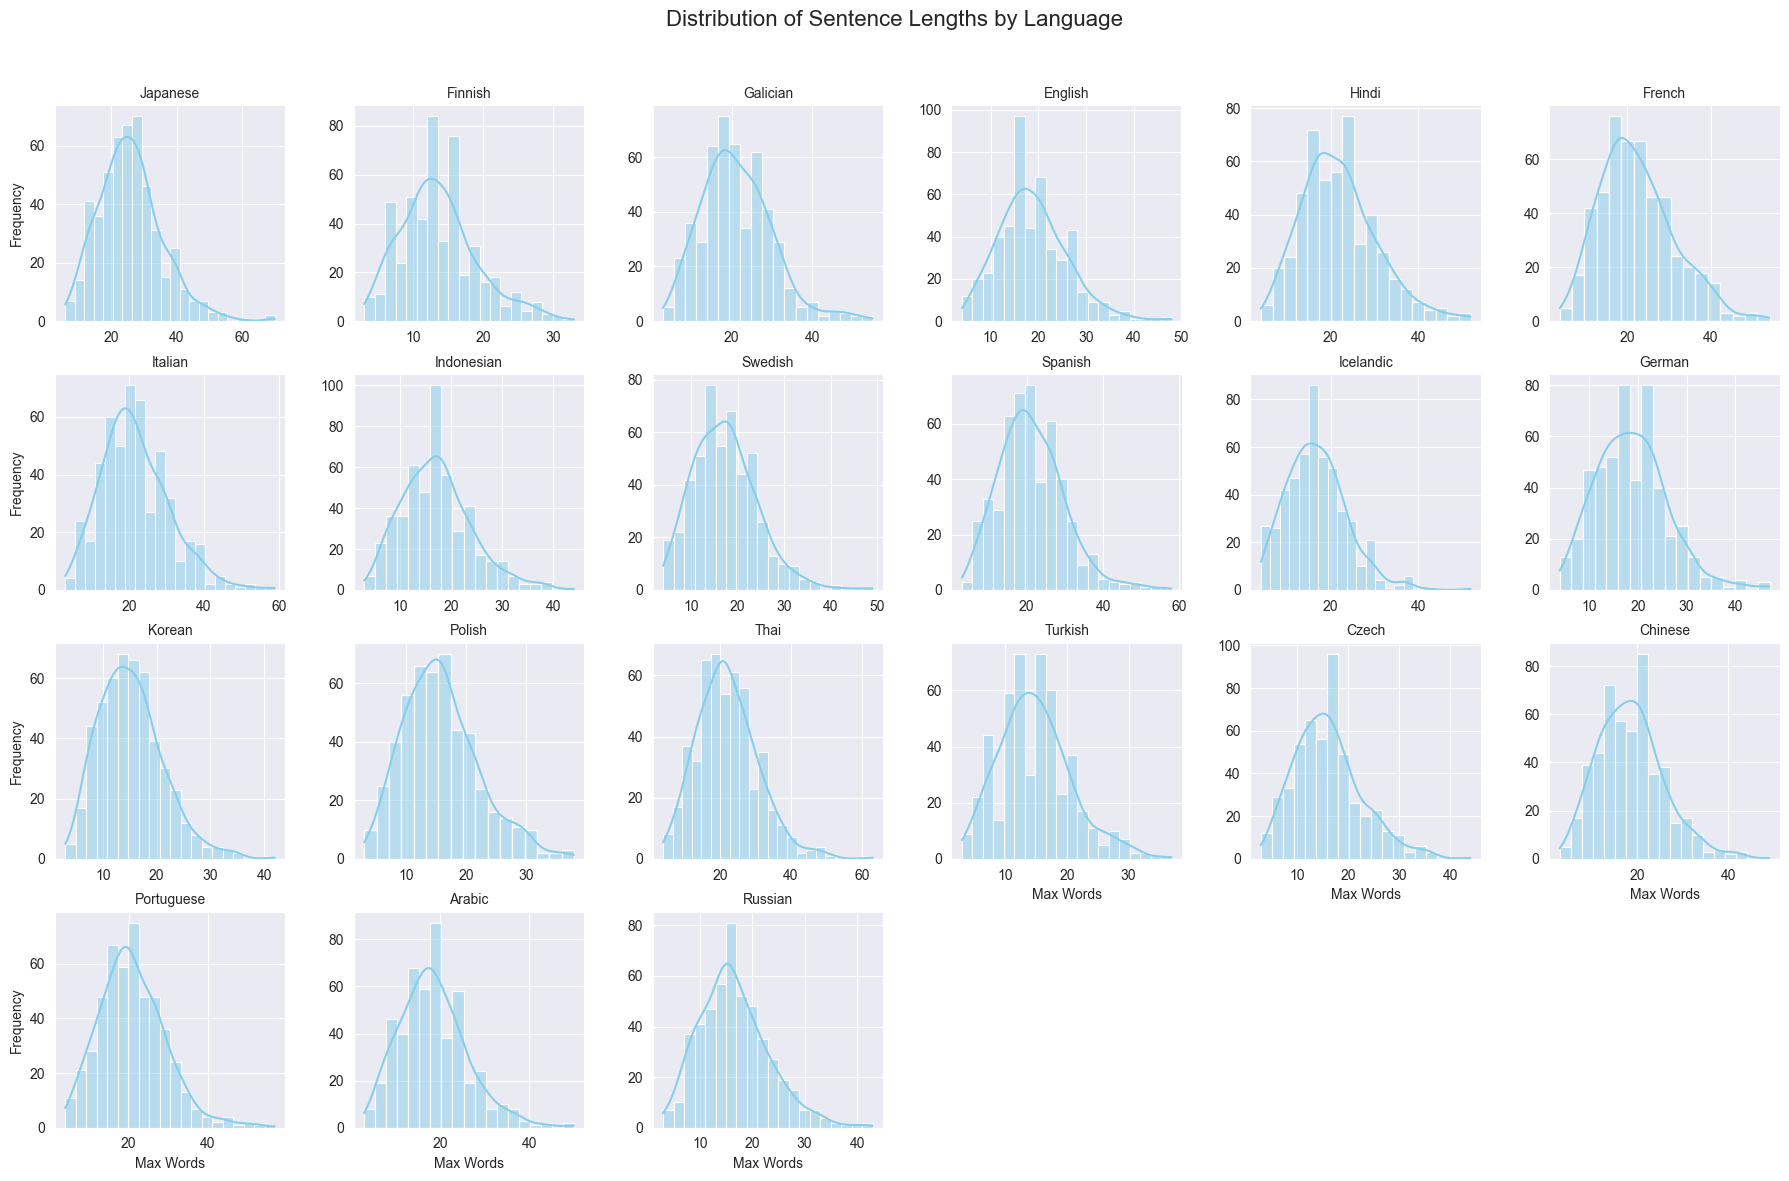

In [7]:
g = sns.FacetGrid(data, col="language", col_wrap=6, sharex=False, sharey=False)

g.map(sns.histplot, "n", kde=True, color="skyblue")

g.set_titles(col_template="{col_name}")
g.set_axis_labels("Max Words", "Frequency")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Distribution of Sentence Lengths by Language", fontsize=16)

plt.show()

Next we can check the important word count statistics for an average sentence of every language in an integrated plot:

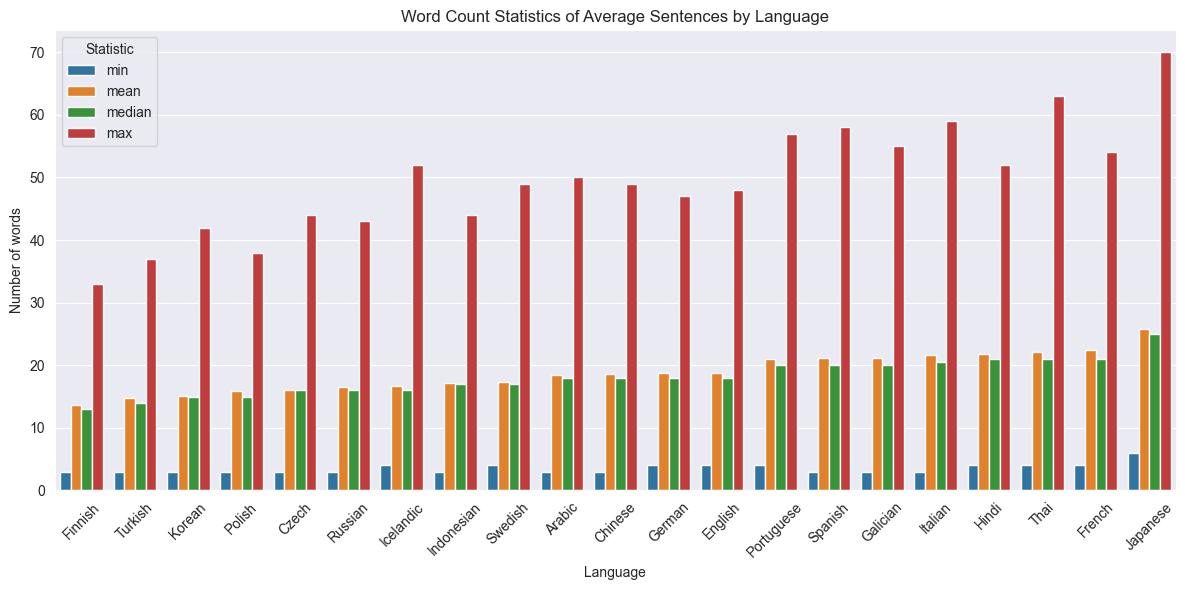

In [8]:
agg_language_df = data.groupby('language')['n'].agg(['min', 'mean', 'median', 'max']).reset_index().sort_values(by='mean')

melted = agg_language_df.melt(id_vars='language', var_name='Statistic', value_name='Value')

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=melted, x='language', y='Value', hue='Statistic')

plt.title('Word Count Statistics of Average Sentences by Language')
plt.ylabel('Number of words')
plt.xlabel('Language')
plt.legend(title='Statistic')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Noticable insights:
- Japanese has on average the highest word count per sentence with $25.8$ while Finnish has the lowest word count with $13.5$. This can be explained by finnish packing a lot of meaning into single words and japanese using a lot of separate words for the same meaning
- Polish, Czech and Russian have similar sentence statistics since they stem from the same language family of slavic languages
- German and English almost have identical statistics since they are both Germanic languages
- Portuguese, Spanish, Italian, and Galician also have similar statistics which can explained from them being romance languages, meaning they descend from Latin.


# Graph per Language

We analyze the graphs for every language to get insights into what can be a good idea to be used for feature engeneering later. We try to:
- Compute simple graph-level and node-level metrics (degrees, leaf status).
- Measure, by language, how often the true root is a leaf.
- Define and visualize features (distance-based, subtree-based, motif counts, spectral, global metrics).

In [9]:
train = data.copy()
train['edgelist'] = train['edgelist'].apply(ast.literal_eval)

For each sentence, we build a graph, compute degrees, and mark the leaf nodes (degree == 1, meaning the number of edges linked to that specific node is 1)

In [10]:
rows = []
for _, row in train.iterrows():
    lang = row['language']
    sent = row['sentence']
    root = row['root']
    edges = row['edgelist']
    G = nx.from_edgelist(edges)
    # degree dict: node -> degree
    deg = dict(G.degree())
    for node, d in deg.items():
        rows.append({
            'language': lang,
            'sentence': sent,
            'vertex': node,
            'is_leaf': (d == 1),
            'is_root': (node == root)
        })

node_df = pd.DataFrame(rows)

Now we compute for each language, the fraction of sentences whose root is a leaf:

In [11]:
root_nodes = node_df[node_df['is_root']]
# Group by language
lang_stats = (
    root_nodes
    .groupby('language')['is_leaf']
    .agg(['mean', 'count'])
    .rename(columns={'mean': 'prop_root_is_leaf', 'count': 'n_sentences'})
    .reset_index()
    .sort_values(by='prop_root_is_leaf')
)

print(lang_stats)

      language  prop_root_is_leaf  n_sentences
7       German              0.000          500
3      English              0.002          500
18     Swedish              0.008          500
5       French              0.008          500
9    Icelandic              0.016          500
10  Indonesian              0.028          500
16     Russian              0.028          500
15  Portuguese              0.028          500
19        Thai              0.034          500
4      Finnish              0.036          500
17     Spanish              0.038          500
11     Italian              0.042          500
6     Galician              0.046          500
20     Turkish              0.050          500
2        Czech              0.056          500
0       Arabic              0.064          500
14      Polish              0.078          500
1      Chinese              0.088          500
13      Korean              0.088          500
8        Hindi              0.176          500
12    Japanes

Next we visualize the results:

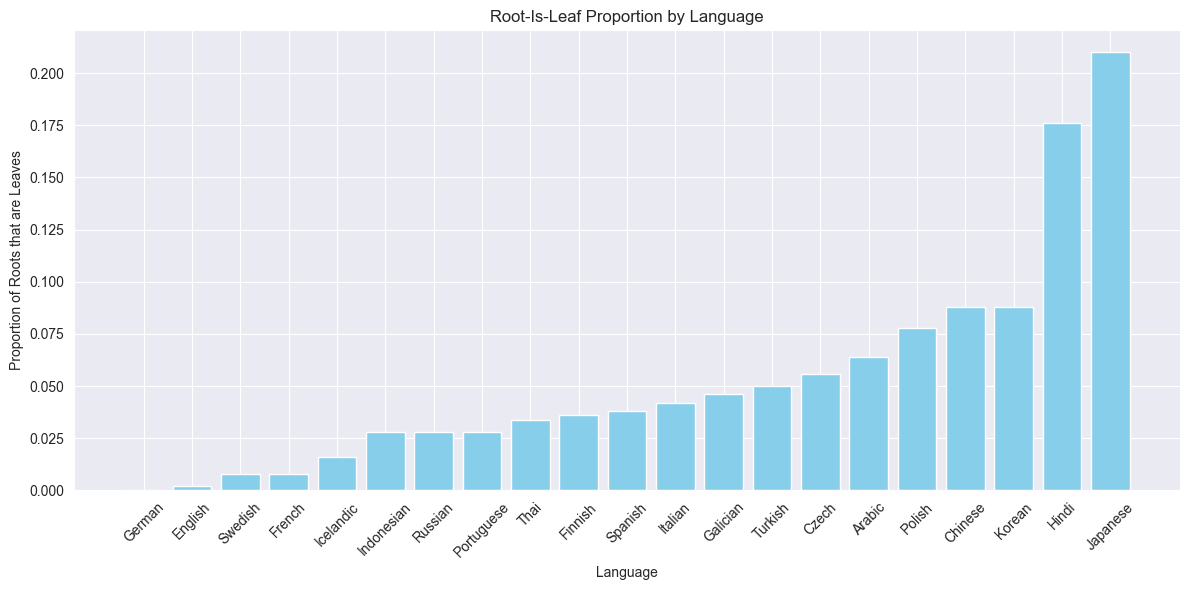

In [12]:
plt.figure(figsize=(12,6))
plt.bar(lang_stats['language'], lang_stats['prop_root_is_leaf'], color='skyblue')
plt.xticks(rotation=45)
plt.ylabel('Proportion of Roots that are Leaves')
plt.xlabel('Language')
plt.title('Root-Is-Leaf Proportion by Language')
plt.tight_layout()
plt.show()

Some languages (e.g., Japanese, Hindi) have higher likelihood of the root being a leaf. This is one of the reasons why these languages have the lower validation and test accuracies as will be seen later on

#### Other metrics
We also compare other metrics. In detail, for each sentence tree, we compute a set of the following features:

1. **Distance‐Based Features:** eccentricity, distance to tree center, min/max distance to leaves.
2. **Subtree‐Based Features:** subtree size stats and tree height if rooted at each node.
3. **Local Motifs and Degree Stats:** number of 2-hop paths through node, neighbor-degree moments and entropy.
4. **Spectral Feature:** Fiedler vector entry from the graph Laplacian.
5. **Global Tree Metrics (joined):** diameter, radius, and balancedness (split size difference along a diameter edge).

In [13]:
data_rows = []
for _, row in train.iterrows():
    lang = row.language
    sent = row.sentence
    root = row.root
    edges = row.edgelist
    T = nx.Graph(edges)
    n = T.number_of_nodes()

    # global metrics
    diam = nx.diameter(T)
    rad  = nx.radius(T)
    # For balancedness: longest path endpoints
    # Approx: pick one endpoint w/ eccentricity
    ecc = nx.eccentricity(T)
    far = max(ecc.items(), key=lambda x: x[1])[0]
    lengths = nx.single_source_shortest_path_length(T, far)
    other = max(lengths.items(), key=lambda x: x[1])[0]
    path = nx.shortest_path(T, far, other)
    # remove middle edge to split into two halves sizes
    mid = len(path)//2
    u, v = path[mid-1], path[mid]
    # copy graph and remove edge
    Gtmp = T.copy()
    Gtmp.remove_edge(u, v)
    comp = list(nx.connected_components(Gtmp))
    half_sizes = [len(c) for c in comp]
    bal = abs(half_sizes[0] - half_sizes[1]) / n

    # Leaves set
    leaves = {node for node,deg in T.degree() if deg==1}

    # Laplacian Fiedler vector
    L = nx.laplacian_matrix(T).astype(float)
    # get 2nd smallest eigenvector
    try:
        from scipy.sparse.linalg import eigsh
        vals, vecs = eigsh(L, k=2, which='SM')
        fiedler = vecs[:,1]
    except Exception:
        fiedler = [0]*n

    # Degrees
    deg_dict = dict(T.degree())

    # For each node
    for node in T.nodes():
        # distances
        dist = dict(nx.single_source_shortest_path_length(T, node))
        ecc_n = ecc[node]
        # distance to center(s)
        centers = nx.center(T)
        d_center = min(nx.shortest_path_length(T, node, c) for c in centers)
        # leaf distances
        d_leaf = [dist[l] for l in leaves]
        min_leaf = min(d_leaf)
        max_leaf = max(d_leaf)
        # subtree sizes: for each neighbor, size of component when removing edge
        neigh = list(T.neighbors(node))
        sub_sizes = []
        for nbr in neigh:
            G2 = T.copy()
            G2.remove_edge(node, nbr)
            # component containing nbr
            comp_n = [c for c in nx.connected_components(G2) if nbr in c][0]
            sub_sizes.append(len(comp_n))
        # tree height
        height = max(dist.values())
        # length-2 paths through node = sum(deg(neighbor)-1)
        path2 = sum(deg_dict[nbr]-1 for nbr in neigh)
        # neighbor-degree stats
        nbr_degs = [deg_dict[n] for n in neigh]
        nbr_deg_mean = np.mean(nbr_degs) if neigh else 0
        nbr_deg_max  = np.max(nbr_degs) if neigh else 0
        nbr_deg_min  = np.min(nbr_degs) if neigh else 0
        # neighbor-degree entropy
        counts = np.bincount(nbr_degs)
        e_nbr = entropy(counts[counts>0])
        # fiedler entry for this node
        f_val = fiedler[list(T.nodes()).index(node)] if len(fiedler)>list(T.nodes()).index(node) else 0

        data_rows.append({
            'language': lang,
            'sentence': sent,
            'vertex': node,
            'is_root': node==root,
            'degree': deg_dict[node],
            'eccentricity': ecc_n,
            'dist_center': d_center,
            'min_leaf_dist': min_leaf,
            'max_leaf_dist': max_leaf,
            'sub_max': max(sub_sizes) if sub_sizes else 0,
            'sub_min': min(sub_sizes) if sub_sizes else 0,
            'sub_var': np.var(sub_sizes) if sub_sizes else 0,
            'height_if_root': height,
            'path2': path2,
            'nbr_deg_mean': nbr_deg_mean,
            'nbr_deg_max': nbr_deg_max,
            'nbr_deg_min': nbr_deg_min,
            'nbr_deg_entropy': e_nbr,
            'fiedler': f_val,
            'diameter': diam,
            'radius': rad,
            'balancedness': bal
        })

node_feats = pd.DataFrame(data_rows)

We visualize a **selected subset of features** (eccentricity, dist_center, min_leaf_dist, sub_max, height_if_root) using KDE plots per language for roots vs. non-roots.

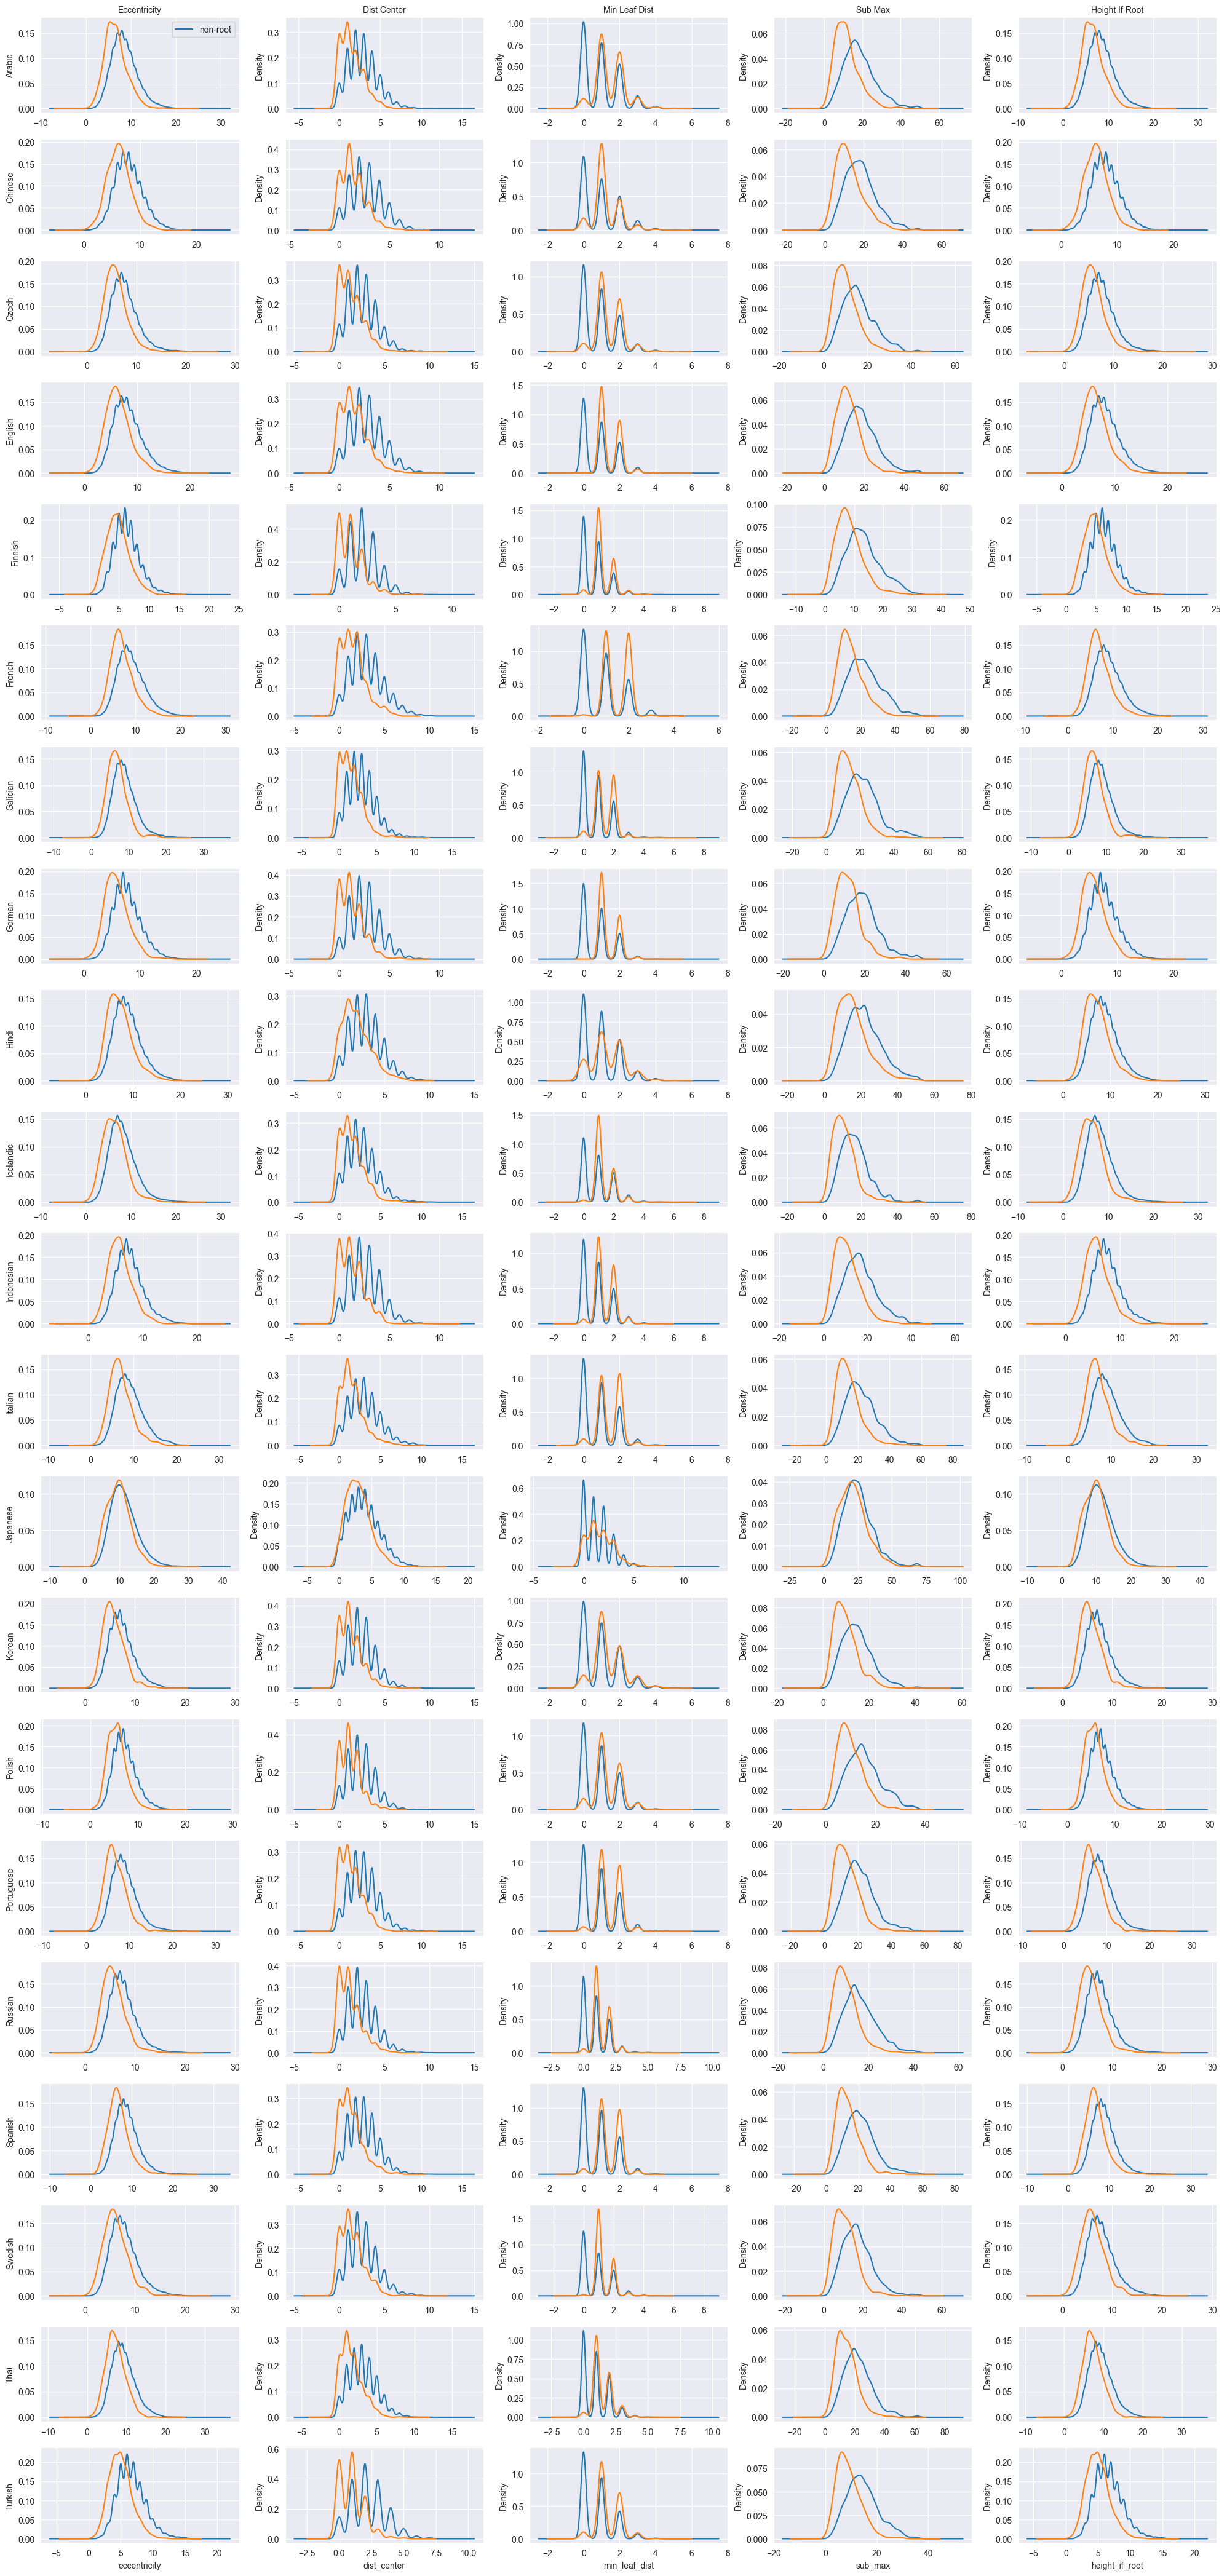

In [14]:
features = [
    'eccentricity',
    'dist_center',
    'min_leaf_dist',
    'sub_max',
    'height_if_root'
]
langs = sorted(node_feats['language'].unique())

fig, axes = plt.subplots(
    nrows=len(langs),
    ncols=len(features),
    figsize=(4*len(features), 2*len(langs)),
    sharex=False,   
    sharey=False 
)

for i, lang in enumerate(langs):
    df_lang = node_feats[node_feats['language'] == lang]
    for j, feat in enumerate(features):
        ax = axes[i, j]
        # plot non-root
        df_lang[df_lang['is_root'] == False][feat].plot(
            kind='kde', ax=ax, label='non-root', legend=(i==0 and j==0)
        )
        # plot root
        df_lang[df_lang['is_root'] == True][feat].plot(
            kind='kde', ax=ax, label='root', legend=False
        )
        # titles on top row
        if i == 0:
            ax.set_title(feat.replace('_', ' ').title(), fontsize=10)
        if j == 0:
            ax.set_ylabel(lang, fontsize=10)
        if i == len(langs) - 1:
            ax.set_xlabel(feat, fontsize=10)

plt.tight_layout(h_pad=1.0, w_pad=0.5)
plt.show()

## Dataset preparation
Now the dataset will be transformed into a training set suitable for binary classification models using centralities as
vertex features

A function is created that transform an edge list into a networkx graph calculating the centralities

In [15]:
def centralities(edgelist):
    T = nx.from_edgelist(edgelist)
    degree = nx.degree_centrality(T)
    closeness = nx.closeness_centrality(T)
    harmonic = nx.harmonic_centrality(T)
    betweeness = nx.betweenness_centrality(T,seed=1)
    load = nx.load_centrality(T)
    pagerank = nx.pagerank(T)
    eigenvector = nx.eigenvector_centrality_numpy(T)
    katz = nx.katz_centrality_numpy(T)
    information = nx.information_centrality(T)
    current_flow_betweenness = nx.current_flow_betweenness_centrality(T)
    percolation = nx.percolation_centrality(T)
    second_order = nx.second_order_centrality(T)
    laplacian = nx.laplacian_centrality(T)
    return {v: (degree[v], closeness[v], harmonic[v], betweeness[v],
                load[v], pagerank[v], eigenvector[v], katz[v], information[v],
                current_flow_betweenness[v], percolation[v],
                second_order[v], laplacian[v]) for v in T}

Now we iterate over each row of the training data, transforming it into a graph and calculating the centralities for every node. The new binary dataset contains the features of `language`, `sentence`,`n`, `vertex`, the various centrality scores and `is_root` (which takes values of 0 or 1 if the particular node is a root node). Since we lose all the information regarding the edges, we decided to use as many centrality measures as possible to retain as much of the semantic information as possible:

In [16]:
columns = ['language', 'sentence', 'vertex', 'n',
           'degree', 'closeness', 'harmonic', 'betweeness', 'load', 'pagerank',
           'eigenvector', 'katz', 'information', 'current_flow_betweeness',
           'percolation', 'second_order', 'laplacian', 'is_root']
binary_data_list = []
# Saving column of edges as a list instead of a string
data['edgelist'] = data['edgelist'].apply(ast.literal_eval)

for row in data.itertuples(index=False):
    for node, (degree, closeness, harmonic, betweeness, load,
              pagerank, eigenvector, katz, information, current_flow_betweeness,
              percolation, second_order, laplacian) in centralities(row.edgelist).items():
        new_row = {'language': row.language,
                   'sentence': row.sentence,
                   'vertex': node,
                   'n': row.n,
                   'degree': degree,
                   'closeness': closeness,
                   'harmonic': harmonic,
                   'betweeness': betweeness,
                   'load': load,
                   'pagerank': pagerank,
                   'eigenvector': eigenvector,
                   'katz': katz,
                   'information': information,
                   'current_flow_betweeness': current_flow_betweeness,
                   'percolation': percolation,
                   'second_order': second_order,
                   'laplacian': laplacian,
                   'is_root': 1 if node == row.root else 0}
        binary_data_list.append(new_row)

expanded_data = pd.DataFrame(binary_data_list, columns=columns)
expanded_data.head(5)

,language,sentence,vertex,n,degree,closeness,harmonic,betweeness,load,pagerank,eigenvector,katz,information,current_flow_betweeness,percolation,second_order,laplacian,is_root
0,Japanese,2,6,23,0.090909,0.159420,5.823846,0.090909,0.090909,0.048565,0.149505,0.209086,0.007246,0.090909,0.090909,98.762341,0.101449,0
1,Japanese,2,4,23,0.045455,0.138365,4.561122,0.000000,0.000000,0.027162,0.068517,0.188298,0.006289,0.000000,0.000000,112.481110,0.043478,0
2,Japanese,2,2,23,0.136364,0.184874,6.991703,0.255411,0.255411,0.066901,0.257706,0.228660,0.008403,0.255411,0.255411,84.451169,0.159420,0
3,Japanese,2,23,23,0.045455,0.157143,5.157179,0.000000,0.000000,0.025477,0.118104,0.190256,0.007143,0.000000,0.000000,100.149888,0.057971,0
4,Japanese,2,20,23,0.090909,0.211538,7.146825,0.311688,0.311688,0.042552,0.294710,0.213357,0.009615,0.311688,0.311688,71.147734,0.130435,0


Next we can normalize the centrality measures of training data but within the same sentence group of the same language:
- Different languages mean different trees (in word order or number of words) and thus centrality values can't be compared directly across languages
- Different sentences also mean different trees



In [17]:
centrality_cols = [
    'degree', 'closeness', 'harmonic', 'betweeness', 'load', 'pagerank', 
    'eigenvector', 'katz', 'information', 'current_flow_betweeness', 
    'percolation', 'second_order', 'laplacian'
]

# Function to apply StandardScaler in each sentence & language group
def scale_within_sentence(group):
    scaler = StandardScaler()
    group[centrality_cols] = scaler.fit_transform(group[centrality_cols])
    return group

expanded_data.to_csv('../data/expanded_train.csv', index=False)
normalized_expanded_data = expanded_data.groupby(['language', 'sentence'], group_keys=False).apply(scale_within_sentence).reset_index(drop=True)
normalized_expanded_data.to_csv('../data/normalized_expanded_train.csv', index=False)
normalized_expanded_data.head(5)

C:\Users\stef4\AppData\Local\Temp\ipykernel_2440\3130652983.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalized_expanded_data = expanded_data.groupby(['language', 'sentence'], group_keys=False).apply(scale_within_sentence).reset_index(drop=True)


,language,sentence,vertex,n,degree,closeness,harmonic,betweeness,load,pagerank,eigenvector,katz,information,current_flow_betweeness,percolation,second_order,laplacian,is_root
0,Japanese,2,6,23,0.133038,-0.558160,-0.308023,-0.676962,-0.676962,0.409538,-0.327923,0.074694,-0.558160,-0.676962,-0.676962,0.489782,-0.031273,0
1,Japanese,2,4,23,-1.396899,-1.111953,-1.442852,-1.126101,-1.126101,-1.313638,-1.131636,-1.460142,-1.111953,-1.126101,-1.126101,1.149235,-1.469827,0
2,Japanese,2,2,23,1.662975,0.111311,0.741550,0.135764,0.135764,1.885752,0.745846,1.519954,0.111311,0.135764,0.135764,-0.198147,1.407281,0
3,Japanese,2,23,23,-1.396899,-0.618060,-0.907167,-1.126101,-1.126101,-1.449223,-0.639537,-1.315616,-0.618060,-1.126101,-1.126101,0.556481,-1.110188,0
4,Japanese,2,20,23,0.133038,0.812630,0.880961,0.413803,0.413803,-0.074579,1.113070,0.390094,0.812630,0.413803,0.413803,-0.837635,0.688004,0


We can do the same steps for the test dataset and save it as a csv:

In [18]:
columns = ['language', 'sentence', 'vertex', 'n',
           'degree', 'closeness', 'harmonic', 'betweeness', 'load', 'pagerank',
           'eigenvector', 'katz', 'information', 'current_flow_betweeness',
           'percolation', 'second_order', 'laplacian']
binary_data_list = []
# Saving column of edges as a list instead of a string
test['edgelist'] = test['edgelist'].apply(ast.literal_eval)

for row in test.itertuples(index=False):
    for node, (degree, closeness, harmonic, betweeness, load,
              pagerank, eigenvector, katz, information, current_flow_betweeness,
              percolation, second_order, laplacian) in centralities(row.edgelist).items():
        new_row = {'language': row.language,
                   'sentence': row.sentence,
                   'vertex': node,
                   'n': row.n,
                   'degree': degree,
                   'closeness': closeness,
                   'harmonic': harmonic,
                   'betweeness': betweeness,
                   'load': load,
                   'pagerank': pagerank,
                   'eigenvector': eigenvector,
                   'katz': katz,
                   'information': information,
                   'current_flow_betweeness': current_flow_betweeness,
                   'percolation': percolation,
                   'second_order': second_order,
                   'laplacian': laplacian}
        binary_data_list.append(new_row)

expanded_test_data = pd.DataFrame(binary_data_list, columns=columns)
normalized_expanded_test_data = expanded_test_data.groupby(['language', 'sentence'], group_keys=False).apply(scale_within_sentence).reset_index(drop=True)
normalized_expanded_test_data.to_csv('../data/normalized_expanded_test.csv', index=False)
normalized_expanded_test_data.head(5)

C:\Users\stef4\AppData\Local\Temp\ipykernel_2440\3596959233.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normalized_expanded_test_data = expanded_test_data.groupby(['language', 'sentence'], group_keys=False).apply(scale_within_sentence).reset_index(drop=True)


,language,sentence,vertex,n,degree,closeness,harmonic,betweeness,load,pagerank,eigenvector,katz,information,current_flow_betweeness,percolation,second_order,laplacian
0,Japanese,1,38,43,0.043173,0.114668,0.270083,-0.710642,-0.710642,0.120017,-0.482073,0.031637,0.114668,-0.710642,-0.710642,-0.204072,-0.079853
1,Japanese,1,33,43,-0.885052,-0.428544,-0.934764,-0.951023,-0.951023,-0.801517,-0.482239,-1.040168,-0.428544,-0.951023,-0.951023,0.347011,-0.983454
2,Japanese,1,10,43,1.899625,0.766913,1.821878,0.743366,0.743366,1.764984,-0.481724,1.960983,0.766913,0.743366,0.743366,-0.799779,1.727348
3,Japanese,1,24,43,0.043173,-1.078191,-1.090006,-0.710642,-0.710642,0.299057,-0.482315,-0.174878,-1.078191,-0.710642,-0.710642,1.103667,-0.441293
4,Japanese,1,16,43,-0.885052,-1.405190,-1.871333,-0.951023,-0.951023,-0.725446,-0.482330,-1.060820,-1.405190,-0.951023,-0.951023,1.540413,-0.983454


## Feature Engineering Analysis

This chapter presents several feature engineering strategies we tried that try to capture structural and positional cues of candidate root nodes. We evaluate each approach with some exploratory analysis and univariate scoring to try to assess its potential usefulness for binary classification in our other notebook. As it turns out, most of the approaches tried here were not useful and thus they did not make it into the final set of features we used later in our models.

### Approach 1: Normalized Position in Sentence

We define:

$$
\mathrm{pos\_norm} = \frac{\mathrm{vertex}}{n}
$$

where `vertex` is the node’s index and `n` is the sentence length.  We expect roots to cluster near the middle of the sentence. This is of course is captured by the centrality measures, but we wanted to see it as an individual metric and if it has enough separability.

In [19]:
import warnings
from sklearn.exceptions import FitFailedWarning

warnings.filterwarnings("ignore", category=FitFailedWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [20]:
df = pd.read_csv('../data/expanded_train.csv')
df['pos_norm'] = df['vertex'] / df['n']
df[['language','sentence','vertex','n','pos_norm','is_root']].head()

,language,sentence,vertex,n,pos_norm,is_root
0,Japanese,2,6,23,0.260870,0
1,Japanese,2,4,23,0.173913,0
2,Japanese,2,2,23,0.086957,0
3,Japanese,2,23,23,1.000000,0
4,Japanese,2,20,23,0.869565,0


Now we can visualize the distribution of pos_norm: Root vs Non‐Root. The y-axis shows the estimated density — not the count, but the probability density (how concentrated the values are in different regions of pos_norm)

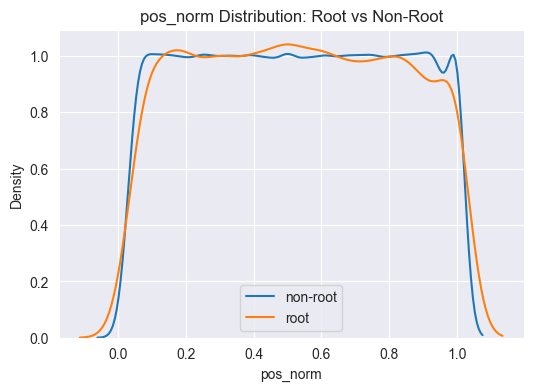

In [21]:
plt.figure(figsize=(6,4))
sns.kdeplot(df[df['is_root']==0]['pos_norm'], label='non-root')
sns.kdeplot(df[df['is_root']==1]['pos_norm'], label='root')
plt.title('pos_norm Distribution: Root vs Non-Root')
plt.xlabel('pos_norm')
plt.ylabel('Density')
plt.legend()
plt.show()

The density plots show very similar distributions for root and non-root nodes and it does not seem useful.

Next the median Root Position by Language:


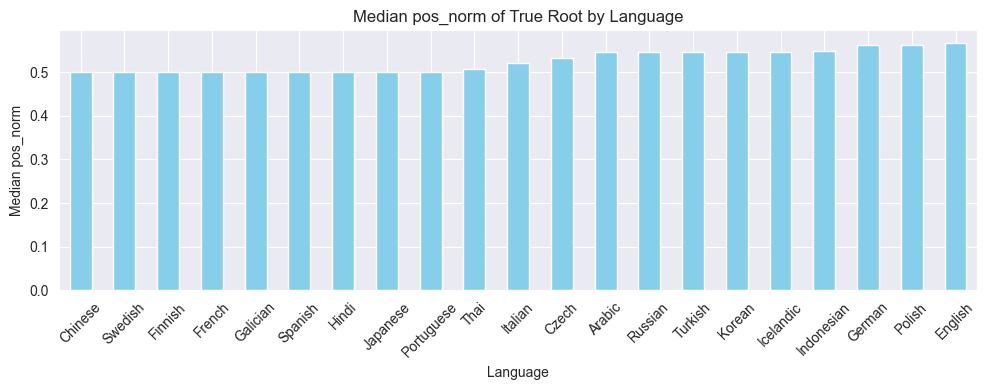

In [22]:
lang_pos = (
    df[df['is_root']==1]
    .groupby('language')['pos_norm']
    .median()
    .sort_values()
)

plt.figure(figsize=(10,4))
lang_pos.plot(kind='bar', color='skyblue')
plt.title('Median pos_norm of True Root by Language')
plt.ylabel('Median pos_norm')
plt.xlabel('Language')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The median root position varies slightly across languages, but all remain near the sentence midpoint.

Next, boxplots of pos_norm for Roots vs Non‐Roots Across Languages

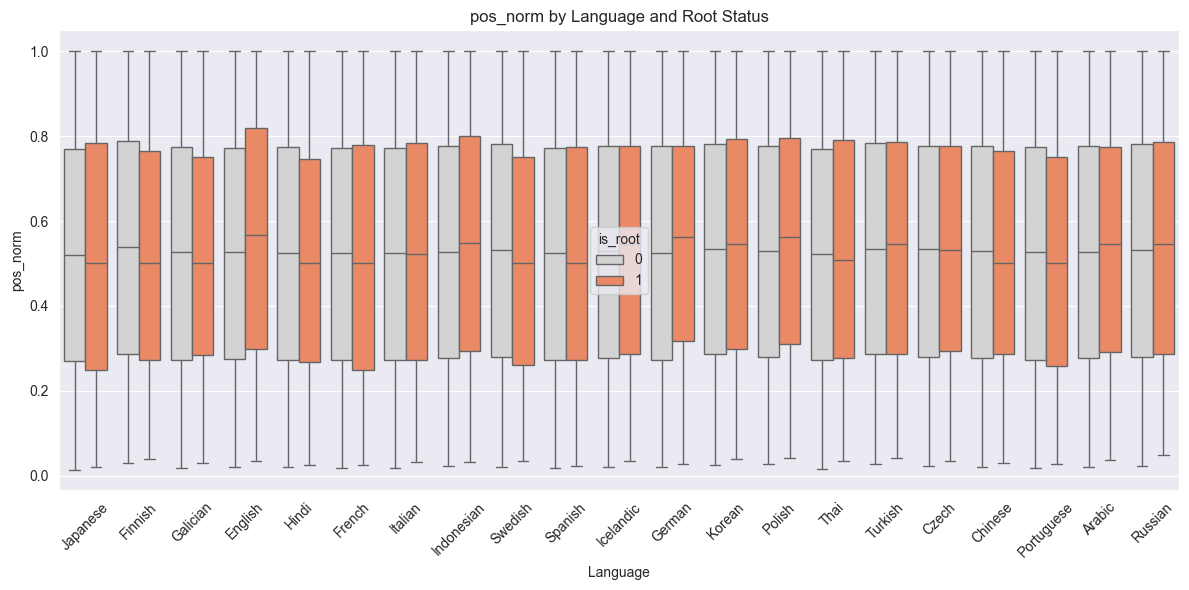

In [23]:
plt.figure(figsize=(12,6))
sns.boxplot(x='language', y='pos_norm', hue='is_root', data=df, palette=['lightgray','coral'])
plt.title('pos_norm by Language and Root Status')
plt.ylabel('pos_norm')
plt.xlabel('Language')
plt.xticks(rotation=45)
plt.legend(title='is_root')
plt.tight_layout()
plt.show()

We also checked the point‐biserial correlation for is_root and pos_norm. The point-biserial correlation is a special case of the Pearson correlation coefficient used when one variable is continuous ( pos_norm) and the other is binary (is_root)

r is the biserial correlation coefficient and p is the associated p-value:

In [24]:
# Compute correlation across entire dataset
corr, pval = pointbiserialr(df['is_root'], df['pos_norm'])
print(f"Point‐biserial corr between is_root and pos_norm: r = {corr:.3f}, p = {pval:.3e}")

# Compute per‐language correlations
lang_corr = []
for lang, grp in df.groupby('language'):
    r, p = pointbiserialr(grp['is_root'], grp['pos_norm'])
    lang_corr.append({'language': lang, 'r': r, 'p': p})
lang_corr = pd.DataFrame(lang_corr).set_index('language').sort_values('r')

print("Per-language correlations:")
print(lang_corr)

Point‐biserial corr between is_root and pos_norm: r = 0.002, p = 2.998e-01
Per-language correlations:
                   r         p
language                      
Finnish    -0.014795  0.222981
Swedish    -0.014363  0.182238
Portuguese -0.008928  0.360670
Hindi      -0.006698  0.484141
Galician   -0.006522  0.501637
French     -0.004776  0.613469
Spanish    -0.004618  0.634563
Chinese    -0.002031  0.844827
Japanese    0.001037  0.906263
Italian     0.001188  0.901560
Czech       0.001589  0.886606
Thai        0.002627  0.782357
Icelandic   0.003403  0.755473
Korean      0.005365  0.640644
Arabic      0.006940  0.504662
Russian     0.007324  0.506623
Turkish     0.008486  0.465105
German      0.014668  0.155424
Polish      0.014855  0.186478
English     0.016940  0.100266
Indonesian  0.018631  0.084499


Very low correlations overall (r ≈ 0.002) and per-language (|r| < 0.02), which means that normalized position is a weak predictor.

### Approach 2: Subtree‐Balance Metrics

Idea: A root node may balance the tree such that removing it splits the structure into relatively even subtrees.

We compute for each node:
1. `max_branch_size`: the size of the largest component when cutting each incident edge.
2. `subtree_entropy`: entropy over branch‐size fractions (how evenly does the data split).

We add the edgelist into the df

In [25]:
train = pd.read_csv('../data/train.csv')
train['edgelist'] = train['edgelist'].apply(ast.literal_eval)

df2 = df.merge(
    train[['language','sentence','edgelist']],
    on=['language','sentence'],
    how='left'
)

Now we compute the two subtree balance features— max_branch_size and subtree_entropy—for each node in a graph (tree) structure:

In [26]:
# subtree‐balance features
def compute_balance(group):
    edges = group['edgelist'].iloc[0]
    T = nx.Graph(edges)
    n = T.number_of_nodes()
    rows = []
    for v in T.nodes():
        sizes = []
        for nbr in T.neighbors(v):
            G2 = T.copy()
            G2.remove_edge(v, nbr)
            for comp in nx.connected_components(G2):
                if nbr in comp:
                    sizes.append(len(comp))
                    break
        max_branch = max(sizes) if sizes else 0
        ent = 0.0
        for s in sizes:
            p = s / n
            ent -= p * log(p, 2) if p > 0 else 0
        rows.append({'max_branch_size': max_branch, 'subtree_entropy': ent})
    # df: one row per node in same order as group
    df_bal = pd.DataFrame(rows)
    return df_bal

bal = (
    df2.groupby(['language','sentence'], group_keys=False)
       .apply(compute_balance)
       .reset_index(drop=True)
)

# merge dfs
df_balance = pd.concat([df2.reset_index(drop=True), bal], axis=1)


C:\Users\stef4\AppData\Local\Temp\ipykernel_2440\2078588991.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_balance)


Next we plot the density of max_branch_size for root and non-root nodes:

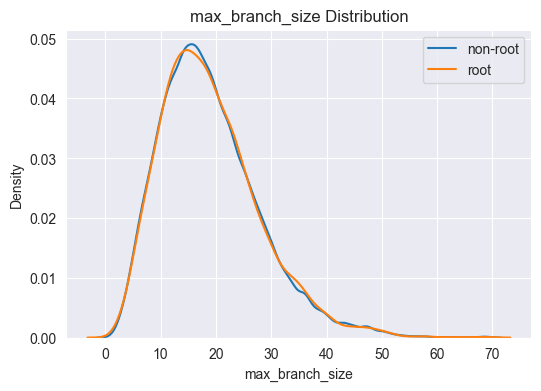

In [27]:
plt.figure(figsize=(6,4))
sns.kdeplot(df_balance[df_balance.is_root==0]['max_branch_size'], label='non-root')
sns.kdeplot(df_balance[df_balance.is_root==1]['max_branch_size'], label='root')
plt.title('max_branch_size Distribution')
plt.xlabel('max_branch_size')
plt.legend()
plt.show()

Also the boxplot of subtree_entropy for each language and for root and non root nodes

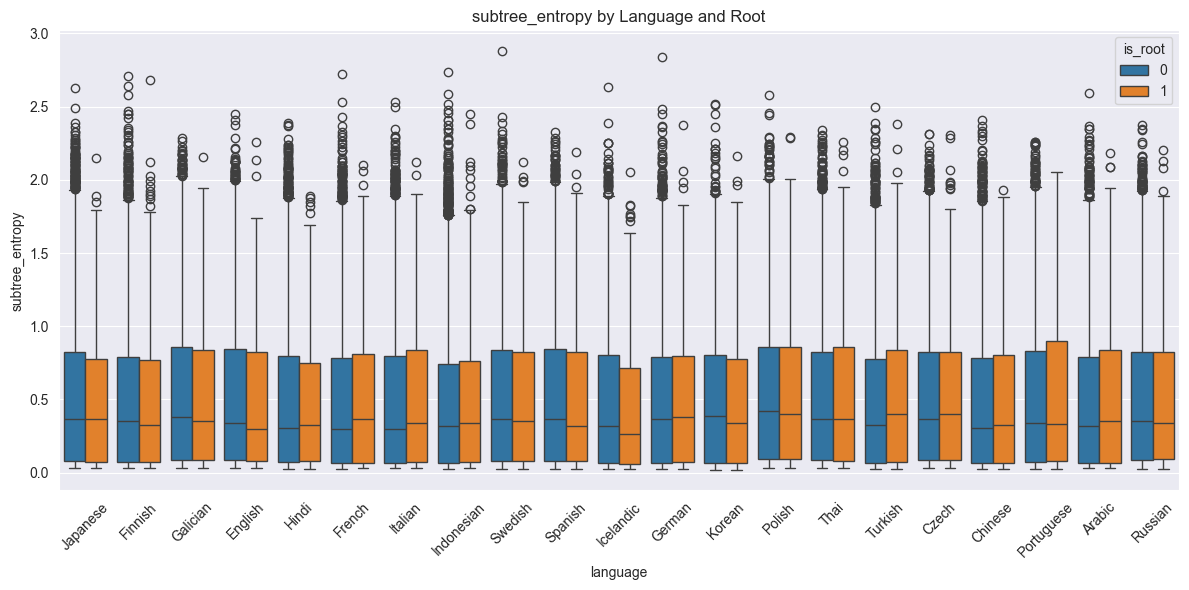

In [28]:
plt.figure(figsize=(12,6))
sns.boxplot(x='language', y='subtree_entropy', hue='is_root', data=df_balance)
plt.title('subtree_entropy by Language and Root')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Last, we score how often the node with the smallest max_branch_size correctly predicts the true root for each sentence in the dataset. 

In [29]:
scores = []
for (lang, sent), grp in df_balance.groupby(['language','sentence']):
    true_root = grp[grp.is_root==1].vertex.values[0]
    pred = grp.loc[grp.max_branch_size.idxmin(), 'vertex']
    scores.append(int(pred==true_root))
print('Root‐accuracy using min max_branch_size:', sum(scores)/len(scores))

Root‐accuracy using min max_branch_size: 0.08838095238095238


Accuracy: ~0.0884 (improvement over random baseline ~1/n), but not much better again, with even more limited separability.m

### Approach 3: Node2Vec Embeddings

We learn 32-dimensional Node2Vec embeddings per node, then analyze their ability to separate root from non-root.

In [30]:
from node2vec import Node2Vec
# For more info: https://github.com/eliorc/node2vec
from sklearn.manifold import TSNE

Now we extract graph-based embeddings using Node2Vec for each node in the graph

In [31]:
emb_rows = []
for _, row in train.iterrows():
    lang, sent, root = row.language, row.sentence, row.root
    edges = row.edgelist
    G = nx.Graph(edges)
    # walks via Node2Vec
    nv = Node2Vec(G, dimensions=32, walk_length=10, num_walks=50, workers=8, quiet=True)
    model = nv.fit(window=5, min_count=1, batch_words=4)
    for node in G.nodes():
        vec = model.wv[str(node)]  # embedding is keyed by string
        emb_rows.append({**{
            'language': lang,
            'sentence': sent,
            'vertex': node,
            'is_root': int(node == root)
        }, **{f'emb_{i}': vec[i] for i in range(32)}})

emb_df = pd.DataFrame(emb_rows)
print("Completed embedding extraction:", emb_df.shape)

Completed embedding extraction: (197479, 36)


Next we perform a t-SNE visualization on a sample of embeddings to visualize how well the Node2Vec embeddings separate "root" and "non-root" nodes in 2D space using t-SNE:

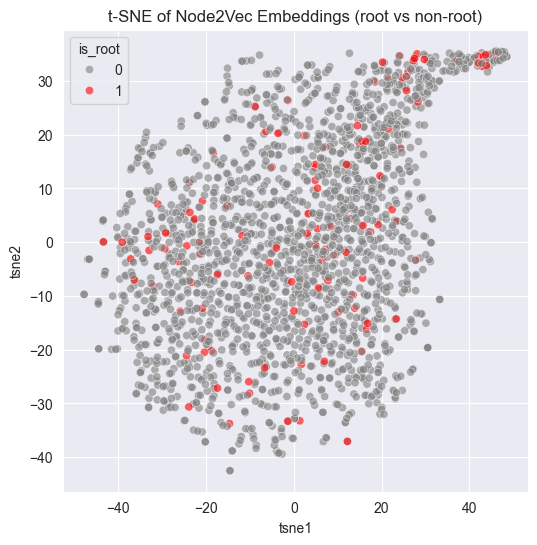

In [32]:
sample = emb_df.sample(n=2000, random_state=1)
X = sample[[f'emb_{i}' for i in range(32)]].values
tsne = TSNE(n_components=2, random_state=0)
Z = tsne.fit_transform(X)
sample['tsne1'], sample['tsne2'] = Z[:,0], Z[:,1]

plt.figure(figsize=(6,6))
sns.scatterplot(data=sample, x='tsne1', y='tsne2', hue='is_root', alpha=0.6, palette=['grey','red'])
plt.title('t-SNE of Node2Vec Embeddings (root vs non-root)')
plt.legend(title='is_root')
plt.show()

Last,  we try a simple univariate root-scoring baseline. It tests whether the token with the largest embedding norm is the root of the sentence

In [33]:
emb_df['emb_norm'] = emb_df[[f'emb_{i}' for i in range(32)]].pow(2).sum(axis=1).pow(0.5)
scores = []
for (_,sent), grp in emb_df.groupby(['language','sentence']):
    true = grp[grp.is_root==1].vertex.values[0]
    pred = grp.loc[grp.emb_norm.idxmax(), 'vertex']
    scores.append(int(pred==true))
print('Root‐accuracy via max embedding norm:', sum(scores)/len(scores))

Root‐accuracy via max embedding norm: 0.08238095238095237


Accuracy: ~0.0892, which is again not much better tha ~1/n baseline.

### Approach 4: Neighbor–Centrality Deltas

Our idea is that a root node may differ from its immediate neighbors in centrality scores. Here we capture how each node’s centrality compares to the average of its immediate neighbors.

In [34]:
df_base = pd.read_csv('../data/expanded_train.csv')

Next the function computes the difference in centrality measures between each node in a graph and the average of its neighbors' centralities

In [35]:
def compute_deltas(group):
    # group corresponds to one sentence, with columns vertex, centralities, and edgelist
    deg = group['degree'].values
    pr  = group['pagerank'].values
    cl  = group['closeness'].values
    bc  = group['betweeness'].values
    # map vertex->index
    vertices = group['vertex'].values
    idx = {v:i for i,v in enumerate(vertices)}
    # build graph from merged edgelist column
    edges = group['edgelist'].iloc[0]
    G = nx.from_edgelist(edges)
    rows = []
    for v in vertices:
        # filter neighbors to those in this group
        nbrs = [u for u in G.neighbors(v) if u in idx]
        if nbrs:
            inds = [idx[n] for n in nbrs]
            rows.append({
                'deg_diff': deg[idx[v]] - deg[inds].mean(),
                'pr_diff' : pr[idx[v]]  - pr[inds].mean(),
                'cl_diff' : cl[idx[v]]  - cl[inds].mean(),
                'bc_diff' : bc[idx[v]]  - bc[inds].mean()
            })
        else:
            rows.append({'deg_diff':0,'pr_diff':0,'cl_diff':0,'bc_diff':0})
    return pd.DataFrame(rows)

Now we can merge the dataframes of expanded nodes and non-expanded nodes to retrieve the edgelist for each node:

In [36]:
df = df_base.merge(
    train[['language','sentence','edgelist']],
    on=['language','sentence'], how='left'
)

Now we can apply the function we created

In [37]:
# apply per-sentence
deltas = (
    df.groupby(['language','sentence'], group_keys=False)
      .apply(compute_deltas)
      .reset_index(drop=True)
)

df_delta = pd.concat([df.reset_index(drop=True), deltas], axis=1)

C:\Users\stef4\AppData\Local\Temp\ipykernel_2440\2649757649.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_deltas)


Now, we create a Kernel Density Estimate plot to compare the distributions of the deg_diff (degree difference) variable between two groups of nodes: root and non-root nodes.

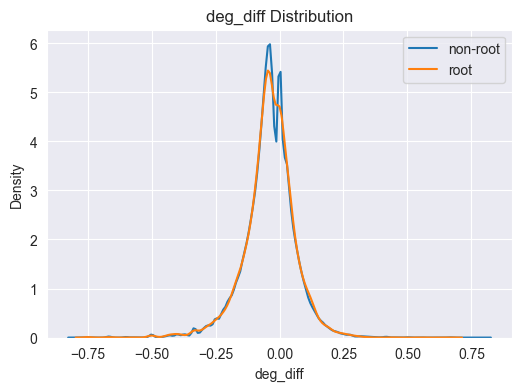

In [38]:
plt.figure(figsize=(6,4))
sns.kdeplot(df_delta[df_delta.is_root==0]['deg_diff'], label='non-root')
sns.kdeplot(df_delta[df_delta.is_root==1]['deg_diff'], label='root')
plt.title('deg_diff Distribution')
plt.xlabel('deg_diff')
plt.legend()
plt.show()

Now we visually explore how different centrality delta values relate to each other, and whether there's a distinction between root and non-root nodes

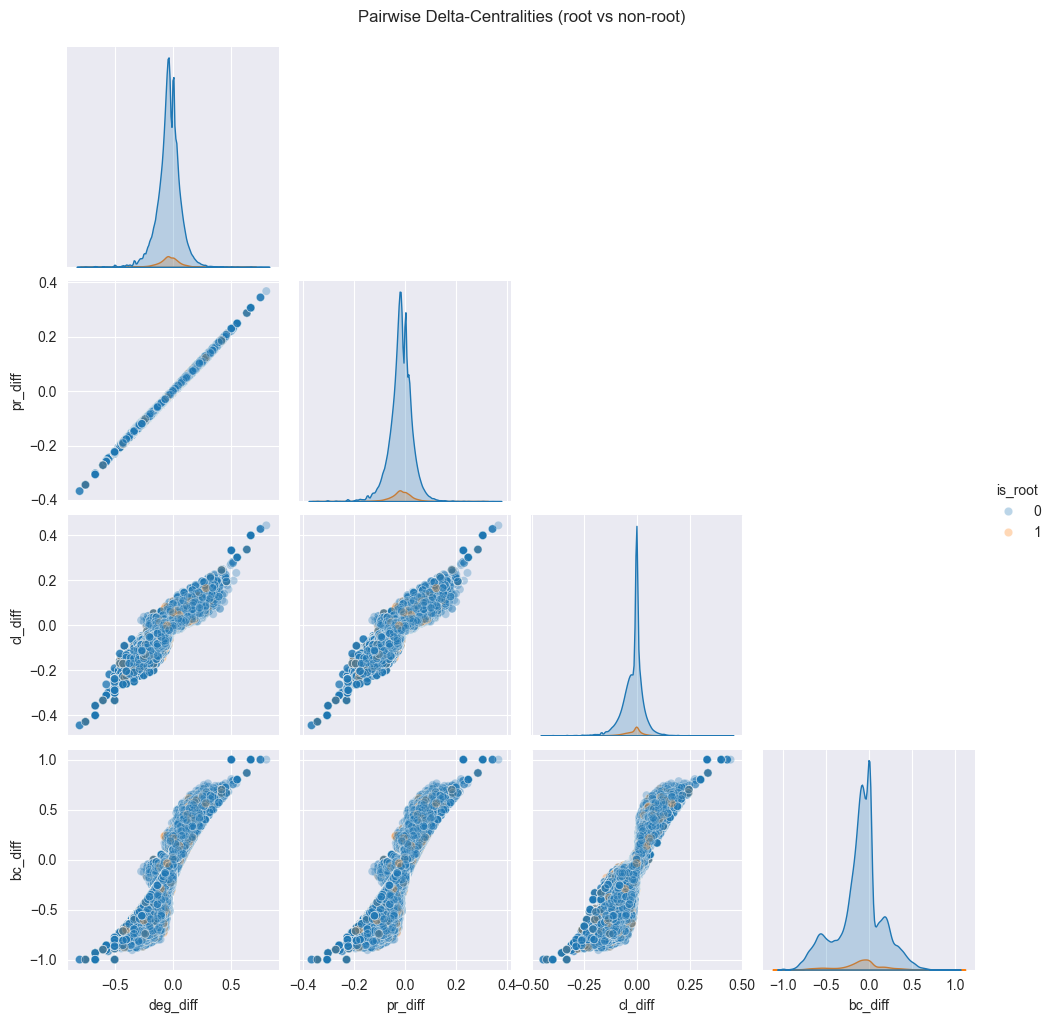

In [39]:
sns.pairplot(
    df_delta[['deg_diff','pr_diff','cl_diff','bc_diff','is_root']],
    hue='is_root', corner=True, plot_kws={'alpha':0.3}
)
plt.suptitle('Pairwise Delta-Centralities (root vs non-root)', y=1.02)
plt.show()

Last, we use a simple heuristic-based classifier for identifying the root node the difference in PageRank centrality between a node and the average of its neighbors:

In [40]:
# Univariate Root‐Accuracy via max pr_diff
pred = []
for (_,sent), grp in df_delta.groupby(['language','sentence']):
    true = grp[grp.is_root==1].vertex.values[0]
    pred_v = grp.loc[grp.pr_diff.idxmax(), 'vertex']
    pred.append(int(pred_v==true))
print('Root‐accuracy via max pr_diff:', np.mean(pred))

Root‐accuracy via max pr_diff: 0.06457142857142857


Here the same happens.

## Approach 5: 1-hop neighbor aggregates

Here, we add to the node-level dataset 1-hop neighbor aggregates of centrality measures and normalizes all of these features within each sentence. We also tried this dataset as our base in our main models, but the benefit we gained in accuracy was very minimal (1%-2%) and it outweighed the performance drop they generated. The part also includes a utility to visualize example trees.

In [41]:
train = pd.read_csv('../data/train.csv')
train['edgelist'] = train['edgelist'].apply(ast.literal_eval)
# Load normalized, expanded node‐level features
expanded = pd.read_csv('../data/normalized_expanded_train.csv')

Function that plots a tree:

In [42]:
def plot_tree(edgelist, root, title=None):
    """
    Draws an undirected tree from its edgelist, with the root node in red.
    """
    T = nx.from_edgelist(edgelist)
    # layout: spring for generality; for strict tree layout, consider graphviz with nx_agraph
    pos = nx.spring_layout(T)
    # color nodes: red for root, skyblue otherwise
    node_colors = ['red' if node == root else 'skyblue' for node in T.nodes()]
    plt.figure(figsize=(6, 6))
    nx.draw(T, pos,
            with_labels=True,
            node_color=node_colors,
            node_size=300,
            edge_color='gray',
            font_size=8)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

Example of plotting:

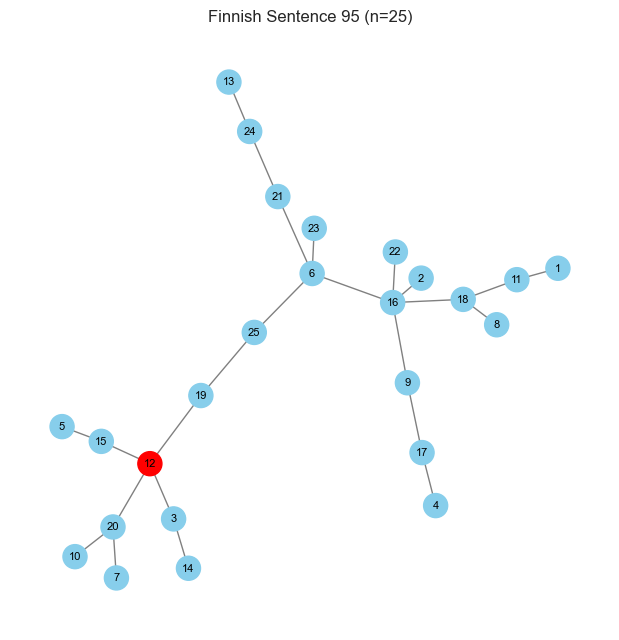

In [43]:
# Find graph based on the row nr. of train (used for exploring numbers)
e0 = train.iloc[546]
plot_tree(e0.edgelist, e0.root,
          title=f"{e0.language} Sentence {e0.sentence} (n={e0.n})")

Loading precomputed node‑level features


In [44]:
columns = [
    'language', 'sentence', 'vertex', 'n',
    'degree', 'closeness', 'harmonic', 'betweeness', 'load', 'pagerank',
    'eigenvector', 'katz', 'information', 'current_flow_betweeness',
    'percolation', 'second_order', 'laplacian', 'is_root'
]
df_cent = pd.read_csv('../data/normalized_expanded_train.csv', usecols=columns)

Explode the `edgelist` into source-neighbor pairs, then create a symmetric adjacency list by adding reversed edges to represent an undirected graph.

In [45]:
edges = (
    train[['language', 'sentence', 'edgelist']]
    .explode('edgelist')
    .assign(u=lambda d: d['edgelist'].str[0],
            v=lambda d: d['edgelist'].str[1])
)
adj = pd.concat([
    edges.rename(columns={'u':'src','v':'nbr'})[['language','sentence','src','nbr']],
    edges.rename(columns={'v':'src','u':'nbr'})[['language','sentence','src','nbr']]
], ignore_index=True)

Merge neighbor nodes in `adj` with their centrality values from `df_cent`, dropping redundant columns afterward

In [46]:
df_nbr = (
    adj
    .merge(df_cent, left_on=['language','sentence','nbr'],
                     right_on=['language','sentence','vertex'],
           how='left')
    .drop(columns=['vertex','is_root','n'])
)

Compute mean, max, and sum statistics of multiple centrality measures over neighbors for each source node.









In [47]:
centralities = [
    'degree', 'closeness', 'harmonic', 'betweeness', 'load', 'pagerank',
    'eigenvector', 'katz', 'information', 'current_flow_betweeness',
    'percolation', 'second_order', 'laplacian'
]
agg_funcs = {c: ['mean','max','sum'] for c in centralities}
nbr_agg = (
    df_nbr
    .groupby(['language','sentence','src'])
    .agg(agg_funcs)
)
nbr_agg.columns = [f"{c}_nhop1_{stat}" for c, stat in nbr_agg.columns]
nbr_agg = nbr_agg.reset_index().rename(columns={'src':'vertex'})

Combine centrality aggregates back into the original node features, filling missing values with zero. Also, prepares a list of feature columns for scaling.









In [48]:
# merge aggregates back to node features
df_aug = (
    df_cent
    .merge(nbr_agg, on=['language','sentence','vertex'], how='left')
    .fillna(0)
)
print("Augmented shape:", df_aug.shape)
print("Columns sample:", df_aug.columns.tolist()[:12])

# exclude non‑feature columns
to_scale = centralities + [f'{c}_nhop1_{stat}' for c in centralities for stat in ['mean','max','sum']]

Augmented shape: (197479, 57)
Columns sample: ['language', 'sentence', 'vertex', 'n', 'degree', 'closeness', 'harmonic', 'betweeness', 'load', 'pagerank', 'eigenvector', 'katz']


Apply standard scaling to selected features within each `language`-`sentence` group, then export the normalized data to CSV.









In [49]:
#scale per sentence
def scale_per_group(g):
    g[to_scale] = StandardScaler().fit_transform(g[to_scale])
    return g

norm_aug = (
    df_aug
    .groupby(['language','sentence'], group_keys=False)
    .apply(scale_per_group)
    .reset_index(drop=True)
)

# Exporting
norm_aug.to_csv('../data/normalized_augmented_train_1hop_allfeatures.csv', index=False)
norm_aug.head(5)

C:\Users\stef4\AppData\Local\Temp\ipykernel_2440\2587348191.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(scale_per_group)


,language,sentence,vertex,n,degree,closeness,harmonic,betweeness,load,pagerank,...,current_flow_betweeness_nhop1_sum,percolation_nhop1_mean,percolation_nhop1_max,percolation_nhop1_sum,second_order_nhop1_mean,second_order_nhop1_max,second_order_nhop1_sum,laplacian_nhop1_mean,laplacian_nhop1_max,laplacian_nhop1_sum
0,Japanese,2,6,23,0.133038,-0.558160,-0.308023,-0.676962,-0.676962,0.409538,...,-0.961448,-0.861890,-0.537040,-0.961448,0.730613,1.021697,0.842049,-0.554857,0.758426,-0.578815
1,Japanese,2,4,23,-1.396899,-1.111953,-1.442852,-1.126101,-1.126101,-1.313638,...,-0.755507,-1.094197,-1.427690,-0.755507,0.748143,0.276860,0.553739,-0.554857,-1.127390,-0.552609
2,Japanese,2,2,23,1.662975,0.111311,0.741550,0.135764,0.135764,1.885752,...,-1.223610,-0.820895,-0.232344,-1.223610,0.230733,0.352194,0.378021,-0.732103,-0.184482,-0.906393
3,Japanese,2,23,23,-1.396899,-0.618060,-0.907167,-1.126101,-1.126101,-1.449223,...,-0.221405,-0.055651,-0.537040,-0.221405,-0.098853,-0.500142,0.123792,1.572094,0.758426,0.652876
4,Japanese,2,20,23,0.133038,0.812630,0.880961,0.413803,0.413803,-0.074579,...,1.076574,1.119547,1.478643,1.076574,-0.906266,-0.500142,-0.819755,1.837963,1.229880,2.133527


 As a conclusion, in this chapter we tried 5 approaches for additional feature engineering besides the ones used in our main models (mostly NetworkX), but none of them had considerable separability, so we decided to discard these in the two main models. Some of them appear in other experimental notebooks, with poor feature importance results (as expected).